<a href="https://colab.research.google.com/github/Viny2030/HUMAI/blob/main/ejercicios_solucionstring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio: búsqueda difusa

Dado el siguiente DataFrame, aplicar la búsqueda difusa de strings para la primera palabra de la descripción de cada producto (columna denominación)

Fuentes:
- http://inal.sifega.anmat.gov.ar/consultadeRegistroAlimentos/
- http://datos.salud.gob.ar/dataset/alimentos-libres-de-gluten/archivo/853d467c-5de5-46ae-bf04-5642c4960d1d

In [1]:
!pip install thefuzz[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.4 MB/s eta 0:00:00


In [2]:
from thefuzz import process, fuzz
import pandas as pd

In [3]:
url = "http://datos.salud.gob.ar/dataset/2ebd602e-3138-40c0-847a-f3eb8f520887/resource/853d467c-5de5-46ae-bf04-5642c4960d1d/download/alimentos-libres-de-gluten.csv"
df = pd.read_csv(url)

In [4]:
df.sample()

,marca,nombre_fantasia,denominacion,RNPA
13803,Genacol Derma,Genacol Derma,Suplemento dietario a base de colágeno hidroli...,21-112721


In [5]:
df['denominacion'].value_counts()

,count
denominacion,
Dulce de leche libre de gluten,74
Queso cremoso libre de gluten,63
Duraznos amarillos en mitades comunes en jarabe diluido – Libre de gluten,47
Queso sardo libre de gluten,45
Queso tybo libre de gluten,44
...,...
Producto de harina de maíz tipo fideo seco - Libre de gluten - (en sus diversos tamaños y formatos),1
Pasta fresca rellena sobre congelada: ravioles libre de gluten sin TACC,1
Pasta fresca rellena sobrecongelada: sorrentinos libre de gluten sin T.A.C.C.,1


Vemos que hay muchas palabras similares pero escritas distinto

- "libre de gluten" / "Libre de Gluten"  
- "sobre congelada" / "sobrecongeladas"  
- etc

In [6]:
# Contar nulos en "denominacion"
df.denominacion.isnull().sum()

1

In [7]:
# Ver los casos donde "denominacion" es nulo
df[df.denominacion.isnull()]

,marca,nombre_fantasia,denominacion,RNPA
6578,;02-567232,NaN,NaN,NaN


In [8]:
# Descartar casos donde "denominacion" es nulo
df = df.dropna(subset=['denominacion'])

Queremos contar la cantidad de alimentos por categoría ("Queso", "Yogur"...).

Para eso vamos a:
 1. Tomar la primer palabra de "denominacion"
 2. Ver con .value_counts() el resultado

Ahí veremos que hay palabras escritas con variaciones, de número u otras (ej "Lomitos", "Lomito"). Entonces vamos a intentar normalizar las palabras. Para eso tenemos dos enfoques:
A) Normalizar con pasos conocidos:
 1. Pasar a minúsculas
 2. Sacar espacios
 3. Sacar tildes
 4. Sacar puntuación

B) Normalizar palabras infrecuentes.
 1. Tomamos las palabras infrecuentes. Para eso podríamos tomar las que están por debajo de cierto percentil (ej. 1%), o las que aparecen una sola vez
 2. Luego, utilizando búsqueda difusa, intentamos matchear las palabras infrecuentes con las más frecuentes

In [9]:
# Nos quedamos con la primer palabra de "denominacion"
# como palabra clave
df.loc[:, 'simple'] = df['denominacion'].apply(lambda x: x.split()[0])
df['simple'].value_counts()

<ipython-input-9-79e5afa51490>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'simple'] = df['denominacion'].apply(lambda x: x.split()[0])


,count
simple,
Queso,1493
Leche,682
Alimento,668
Mermelada,549
Yogur,503
...,...
Estabilizante,1
Lomitos,1
Perejil,1


In [12]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.2 MB/s eta 0:00:00


In [13]:
from unidecode import unidecode
import string

def normalizar(s):
    # todo a minusculas
    s = s.lower()
    # sacar espacios
    s = s.strip()
    # sin tildes
    s = unidecode(s)
    # sacamos puntuacion
    letras_no_punct = [l if l not in string.punctuation else '' for l in s]
    return ''.join(letras_no_punct)

# normalizar('Vainillás,')

In [14]:
def get_match(string, lista_strings):
    """Para buscar coincidencias entre nombre con los nombres"""
    mejor_match, puntaje = process.extractBests(string.strip(), lista_strings, scorer=fuzz.ratio)[0]
    return mejor_match, puntaje

def find_match(busqueda: str, vocab: list, th=85):
    """Si lo encuentra, devuelve el resultado de la búsqueda. Si no, mantiene lo mismo"""
    match, puntaje = get_match(busqueda, vocab)
    if puntaje > th:
        return match
    else:
        return busqueda

In [15]:
# 535 "categorias" distintas
p = df['simple'].value_counts()
p

,count
simple,
Queso,1493
Leche,682
Alimento,668
Mermelada,549
Yogur,503
...,...
Estabilizante,1
Lomitos,1
Perejil,1


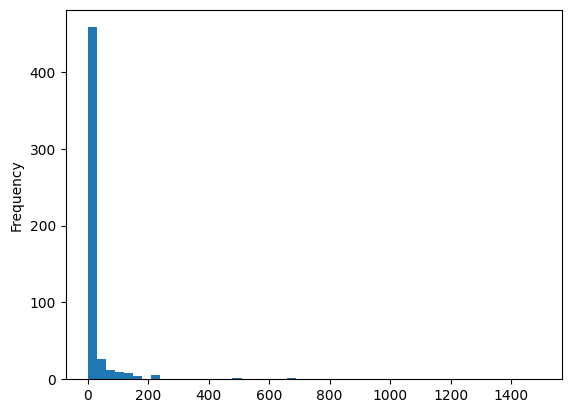

In [16]:
p.plot.hist(bins=50);

In [17]:
p[p == 1].count()

176

In [18]:
dudosas = p[p == 1].index
dudosas

Index(['Trozos', 'Premezcla,', 'Fecula', 'Bastoncitos', 'Biscuits',
       'Polvorones', 'Bebida,', 'Frambuesa', 'Pretzels', 'Guinda',
       ...
       'Acaí', 'Espesantes', 'Cazuela', 'Celulosa', 'Antiaglutinante',
       'Estabilizante', 'Lomitos', 'Perejil', 'Aromatizante/saborizante',
       'Vainillas,'],
      dtype='object', name='simple', length=176)

In [19]:
vocab = p[p > 1].index
vocab

Index(['Queso', 'Leche', 'Alimento', 'Mermelada', 'Yogur', 'Suplemento',
       'Dulce', 'Galletitas', 'Polvo', 'Bebida',
       ...
       'Moras', 'Durazno', 'Rebozador-', 'Pre-pizza', 'Ñoquis', 'Trigo',
       'Amaranto', 'Cereza', 'Garrapiñada', 'Tallarines'],
      dtype='object', name='simple', length=359)

In [20]:
matches = dudosas.map(lambda x: find_match(x, vocab))

In [21]:
matches

Index(['Trozos', 'Premezcla', 'Fecula', 'Bastoncitos', 'Biscuits',
       'Polvorones', 'Bebida', 'Frambuesas', 'Pretzel', 'Guindas',
       ...
       'Acaí', 'Espesante', 'Cazuela', 'Celulosa', 'Antiaglutinante',
       'Estabilizante', 'Lomito', 'Perejil', 'Aromatizante/saborizante',
       'Vainillas'],
      dtype='object', name='simple', length=176)

In [22]:
resultado = pd.DataFrame({'original':dudosas, 'matches':matches})

In [23]:
resultado[resultado['original'] != resultado['matches']]

,original,matches
1,"Premezcla,",Premezcla
6,"Bebida,",Bebida
7,Frambuesa,Frambuesas
8,Pretzels,Pretzel
9,Guinda,Guindas
...,...,...
163,"Mora,",Moras
164,Mora,Moras
167,Espesantes,Espesante
172,Lomitos,Lomito


In [24]:
%%time
df['simple_correct'] = df['simple'].map(lambda x: find_match(x, vocab))

CPU times: user 3.03 s, sys: 3.52 ms, total: 3.04 s
Wall time: 3.21 s


In [25]:
df['simple_correct'].value_counts()

,count
simple_correct,
Queso,1493
Leche,682
Alimento,668
Mermelada,549
Yogur,503
...,...
Estabilizante,1
Antiaglutinante,1
Celulosa,1


# Bonus:
- Aplicar la normalización sobre los nombres completos de los productos.

Va a requerrir un poco más de pasos, ej podrían borrar "sin TACC" (usar RegEx), "libre de gluten"

In [26]:
# prompt: Aplicar la normalización sobre los nombres completos de los productos.
# Va a requerrir un poco más de pasos, ej podrían borrar "sin TACC" (usar RegEx), "libre de gluten"

import re

def normalize_product_name(name):
    """Normalizes product names by removing specific phrases and applying general normalization."""
    name = re.sub(r'\bsin tacc\b', '', name, flags=re.IGNORECASE)  # Remove "sin TACC"
    name = re.sub(r'\blibre de gluten\b', '', name, flags=re.IGNORECASE)  # Remove "libre de gluten"
    name = normalizar(name) # Apply existing normalization
    name = name.strip() # Remove extra whitespace
    return name

# Example usage (assuming 'denominacion' column exists):
df['normalized_name'] = df['denominacion'].apply(normalize_product_name)

# Display the updated DataFrame
print(df[['denominacion', 'normalized_name']].head())


                                     denominacion  \
0       Aceite de maíz, libre de gluten, sin TACC   
1                Aceite de maíz - Libre de gluten   
2         Aceite de oliva virgen libre de gluten.   
3           Aceite de oliva extra libre de gluten   
4  Aceite de oliva virgen extra – Libre de gluten   

                normalized_name  
0                aceite de maiz  
1                aceite de maiz  
2        aceite de oliva virgen  
3         aceite de oliva extra  
4  aceite de oliva virgen extra  
